# The Hawaii Cesspool Hazard Assessment & Prioritization Tool:
# Molokai Version 3


## ................................................ Code Notebook ................................................
*September 2024*

**Prepared For:** 
NOAA Coastal Zone Management Progam

**Principal Investigator and Primary Software Developer** 
- Christopher Shuler Ph.D., Shuler Hydrologic LLC


### Highlights for Version 3
- Updated using existing methodology to include the island of Molokai
- Using a digital ocean space cloud storage bucket to reference large files for the code, so as not to keep them in the repo


### Methods: Input datasets

#### Physical drivers and risk factors
- These are factors that physically control the transport, attenuation, or otherwise affect the level of impact an OSDS at a given location will have on the environment and water quality

- The impact of an individual OSDS depends on an array of factors regarding the substrate within which it is installed, its location and proximity to sensitive areas, the ultimate discharge point of its effluent and the conservative constituents therein, and the cumulative impacts of other nearby OSDS, which together may more quickly overwhelm the adsorption and contaminant attenuation capacity of the subsurface than an individual system would. 
- We considered all numerically or categorically quantifiable factors relating to variability in OSDS impacts, for which we were able to find statewide datasets, we call these "Risk Factors". 
- While some of the risk factor datasets had missing values we generally only included datasets for which we had a minimum of 90% coverage of the OSDS in the state. 
- For each risk factor we defined a scaler relationship or score between the variable and the spatial location of every individual OSDS unit which was then weighted, and averaged with the scores of all other risk factors to produce a single final prioritization ranking 
- for each individual OSDS in our state-wide inventory, we calculated a numeric value based on the relationship between the location of the OSDS unit and the spatial distribution of the risk factor so that every OSDS unit is assigned a score for every risk factor. 


#### Value- based risk factors
While the physical factors control the level of impact, we have also included value-based factors that quantify the spatial distribution of human and environmental value within the areas calculated to be affected by the discharge of cesspool effluent through the use of groundwater flow modeling.

In [2]:
# load up dependencies and local functions
%run functions_v2.py
from IPython.display import Image

# relative paths
homedir = os.getcwd()
if not os.path.exists(os.path.join(homedir,'tempspace')): os.makedirs(os.path.join(homedir,'tempspace'))  
tempspace = os.path.join(homedir, "tempspace")
if not os.path.exists(os.path.join(".", 'Outputs/intermidiate_DataFrames')): os.makedirs(os.path.join(".", 'Outputs/intermidiate_DataFrames'))  
intermidiate_DataFramesPath = os.path.join(".", 'Outputs/intermidiate_DataFrames')

pd.set_option('display.max_rows', 10)

In [3]:
# To save time, load dataframes from the pre-run analysis
for i in os.listdir(intermidiate_DataFramesPath):
    name = i.split(".")[0]
    tempframe = pd.read_csv(os.path.join(intermidiate_DataFramesPath, i), index_col=0)
    globals()[str(name)] = tempframe   # This is sly, use globals to define an in-memory variable 
#osds_path = os.path.join(tempspace, "OSDS_cleaned.shp")

# This takes the directory of CSV files from intermidiate_DataFramesPath, if the code has been run yet) to dynamically
# load each CSV into a separate global variable, where the variable name is based on the CSV file's name.
# In essence, it's automatically loading each CSV into memory as a DataFrame and naming the variables after the CSV file names.

## Download large files >100mb from offsite repo 
note this has a long run time! 

- Some of the files this notebook depends on are too large to be hosted by GitHub
- One solution is to place these files into a cloud-based repositiry, in this case I use Digital Ocean spaces, and then just download them at the beginning of the work session
- Once the analysis is complete there is a cell at the bottom of the notebook to remove these files from the Github Repo so any updates dont include the large files 

In [6]:
### Grab the Lidar elevation data: 
LIDAR_file_urls = ['https://hcpt-large-file-storage.sfo3.digitaloceanspaces.com/Lidar_DEM_molokai/Lidar_DEM/MoKaiLiDar.tfw', 
            'https://hcpt-large-file-storage.sfo3.digitaloceanspaces.com/Lidar_DEM_molokai/Lidar_DEM/MoKaiLiDar.tif.aux.xml',
            'https://hcpt-large-file-storage.sfo3.digitaloceanspaces.com/Lidar_DEM_molokai/Lidar_DEM/MoKaiLiDar.tif.xml', 
            'https://hcpt-large-file-storage.sfo3.digitaloceanspaces.com/Lidar_DEM_molokai/Lidar_DEM/MoKaiLiDar.tif.ovr', 
            'https://hcpt-large-file-storage.sfo3.digitaloceanspaces.com/Lidar_DEM_molokai/Lidar_DEM/MoKaiLiDar.tif']

LIDAR_local_folder = os.path.join("..", "Projected_data\\DEMs\\Lidar_DEM")

download_files_from_public_endpoint(LIDAR_file_urls, LIDAR_local_folder) 

Downloaded MoKaiLiDar.tfw to ..\Projected_data\DEMs\Lidar_DEM\MoKaiLiDar.tfw
Downloaded MoKaiLiDar.tif.aux.xml to ..\Projected_data\DEMs\Lidar_DEM\MoKaiLiDar.tif.aux.xml
Downloaded MoKaiLiDar.tif.xml to ..\Projected_data\DEMs\Lidar_DEM\MoKaiLiDar.tif.xml
Downloaded MoKaiLiDar.tif.ovr to ..\Projected_data\DEMs\Lidar_DEM\MoKaiLiDar.tif.ovr
Downloaded MoKaiLiDar.tif to ..\Projected_data\DEMs\Lidar_DEM\MoKaiLiDar.tif


## Import OSDS File 
##### This creates a clean OSDS file from which all other cells will pull 
Currently using OSDS_v6 which incorporates 2020 updates from the DoH Wastewater branch (v3) IWS Database (V4) as well as the 4 counties tax records dwelling databases (V5).  This can easily be substituted as updates to the OSDS inventory are created.  This version wa run specifically for Molokai based on the Molokai V5 OSDS dataset made for Nancy 

In [5]:
# Read in latest OSDS dataset  has to have an X and Y column in WGS 84

fromshp = os.path.join("..", "Projected_data/OSDS_v6_Exploded/", 'CESSPOOLSv6_Exploded.shp')
OSDS = Format_OSDS_shp(fromshp, cleanitup=True)

# Deal with Dupes
checkdup = OSDS.pivot_table(index=['Uid'], aggfunc='size')
#print(f"there are duplicate points at: {checkdup[checkdup != 1]}")
# remove the duplicates (keep first entry of the duplicate row)
OSDS.drop_duplicates(subset=['Uid'], keep="first", inplace=True)
# Reindex or else the future joins will be based on an index with dupes
OSDS.reset_index(drop=True, inplace=True)

# Save csv
OSDS.to_csv(os.path.join(intermidiate_DataFramesPath, "OSDS.csv"))

# Convert the now formatted OSDS csv back to a shapefile for the subsequent analyses
csvFilePath = os.path.join(intermidiate_DataFramesPath, "OSDS.csv")
convert_OSDS_csv_to_shp(csvFilePath)

# Define the cleaned up OSDS file all the other cells can use
osds_path = os.path.join(tempspace, "OSDS_cleaned.shp")
print("There are {} (OSDS or Cesspools) in this dataset".format(len(OSDS)))

There are 1280 (OSDS or Cesspools) in this dataset


## Distance to Municipal or domestic wells 


Average dist2_MunWells_m is 6136.877258811058
Max dist2_MunWells_m is 27573.79162605669
Min dist2_MunWells_m is 109.26694837034235


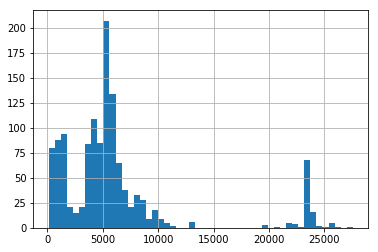

In [9]:
# Generate parameter info about the Municipal wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Wells", 'CWRM_Wells_MUN_prj.shp')
new_col_name = "dist2_MunWells_m"
# Run the near analysis 
MUN_WELLS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
MUN_WELLS.to_csv(os.path.join(intermidiate_DataFramesPath, "MUN_WELLS.csv"))
# plot histogram
Hist_and_stats_on_DF(MUN_WELLS, "dist2_MunWells_m")

Average dist2_DomWells_m is 11132.087318388018
Max dist2_DomWells_m is 36562.96007228427
Min dist2_DomWells_m is 32.432537633769925


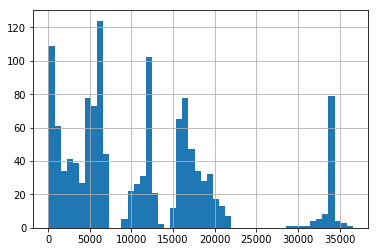

In [10]:
# Generate paramater info about the Domestic wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Wells", 'CWRM_Wells_DOM_prj.shp')
new_col_name = "dist2_DomWells_m"
# Run the near analysis 
DOM_WELLS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
DOM_WELLS.to_csv(os.path.join(intermidiate_DataFramesPath, "DOM_WELLS.csv"))
# plot histogram
Hist_and_stats_on_DF(DOM_WELLS, "dist2_DomWells_m")

## Well capture zones


In [11]:
In_polygons = os.path.join("..", "Projected_data/Well_CZs", 'ZoneB_Composite_Molokai.shp')
new_col_name = 'In_WellCZ_B'
In_points = osds_path

WellCZ_B_yes = Find_points_inside_polys(In_points, In_polygons, new_col_name)
WellCZ_B_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "WellCZ_B_yes.csv"))

print_stats_on_bool_layers(WellCZ_B_yes)

number of affected points = 3
number of total systems = 1280
percent of systems affected = 0.00234375


In [12]:
In_polygons = os.path.join("..", "Projected_data/Well_CZs", 'ZoneC_Composite_Molokai.shp')
new_col_name = 'In_WellCZ_C'
In_points = osds_path

WellCZ_C_yes = Find_points_inside_polys(In_points, In_polygons, new_col_name)
WellCZ_C_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "WellCZ_C_yes.csv"))

print_stats_on_bool_layers(WellCZ_C_yes)

number of affected points = 36
number of total systems = 1280
percent of systems affected = 0.028125


## Distance to streams


Average dist2_Streams_m is 269.36113061910834
Max dist2_Streams_m is 1148.203488529939
Min dist2_Streams_m is 0.175227375914354


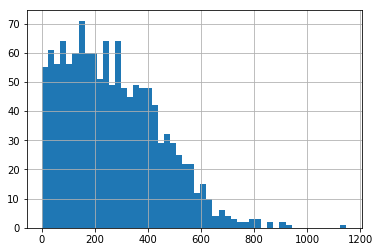

In [13]:
# Generate parameter info about the Municipal wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Streams", 'Streams_prj.shp')
new_col_name = "dist2_Streams_m"
# Run the near analysis 
STREAMS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
STREAMS.to_csv(os.path.join(intermidiate_DataFramesPath, "STREAMS.csv"))
# plot histogram
Hist_and_stats_on_DF(STREAMS, "dist2_Streams_m")

## Distance to Wetlands


Average dist2_Wetlands_m is 1665.5024292484202
Max dist2_Wetlands_m is 8630.798943424586
Min dist2_Wetlands_m is 11.248930451902707


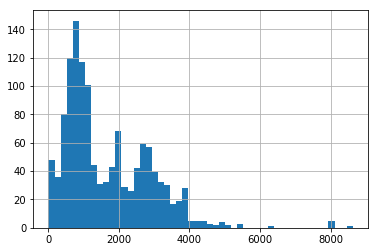

In [14]:
# Generate parameter info about the wetlands
shp_path = os.path.join("..", "Projected_data/Wetlands", 'Wetlands_emergent_ponds.shp')
new_col_name = "dist2_Wetlands_m"
# Run the near analysis 
WETLANDS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
WETLANDS.to_csv(os.path.join(intermidiate_DataFramesPath, "WETLANDS.csv"))
# plot histogram
Hist_and_stats_on_DF(WETLANDS, "dist2_Wetlands_m")

## Distance to the coastline


Average dist2_coast_m is 1015.4681208726258
Max dist2_coast_m is 5113.371334908346
Min dist2_coast_m is 2.692405061562155


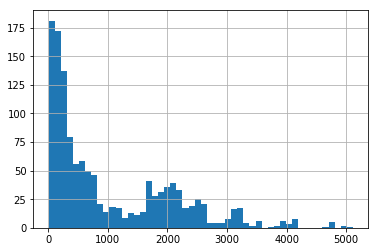

In [15]:
# Generate parameter info about the COASTLINE   looong RUN TIME 
shp_path = os.path.join("..", "Projected_data/Coastline", 'Coastline_line_prj.shp')
new_col_name = "dist2_coast_m"
# Run the near analysis 
COASTLINE = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
COASTLINE.to_csv(os.path.join(intermidiate_DataFramesPath, "COASTLINE.csv"))
# plot histogram
Hist_and_stats_on_DF(COASTLINE, "dist2_coast_m")

## Extracting values from Rainfall raster 


Average rainfall_in is 27.45175240486723
Max rainfall_in is 101.38800048799999
Min rainfall_in is 9.66359329224


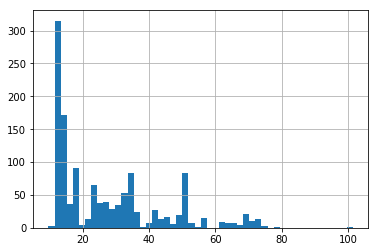

In [16]:
In_raster = os.path.join("..", "Projected_data/Rain", 'Rain_inann.tif')
In_points = osds_path
new_col_name = "rainfall_in"

RAINFALL = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)
RAINFALL.to_csv(os.path.join(intermidiate_DataFramesPath, "RAINFALL.csv"))
# plot histogram
Hist_and_stats_on_DF(RAINFALL, "rainfall_in")

## Soils 


In [17]:
# Pull in soils data from NRCS
In_polygons = os.path.join("..", "Projected_data/Soils", 'HIstate_nrcs_join2.shp')
new_col_name = 'Soil_Ksat_2ndry'
In_points = osds_path

# Columns you want from the shapefile (Uid should always  be first one) 
want_cols = ['Uid', 'brockdepmin', 'flodfreqdcd', 'engstafdcd', 'engstafll', 
             'engstafml', 'cokey', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_r', ]  # 'totalsub_r', slopegradw

renames = {'brockdepmi':'nrcs_DtoBrock', 
 'flodfreqdc':'nrcs_FloodFreq',
 'engstafdcd':'nrcs_septic_dominant', 
 'engstafll':'nrcs_septic_least', 
 'engstafml':'nrcs_septic_most', 
 'ksat_h':'nrcs_ksat_hi',  
 'ksat_l':'nrcs_ksat_lo',
 'ksat_r':'nrcs_ksat_rep', 
 'sieveno10_':'nrcs_rockFrag3in'}    # 'slopegradw':'nrcs_slope', 'totalsub_r':'nrcs_subsidence'

# Do the spatial join
arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(tempspace, "test_join_pt_2_poly.shp"))

# read data from shapefile 
extracted_points_path = os.path.join(tempspace, "test_join_pt_2_poly.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))

want_cols = ['Uid', 'brockdepmi', 'flodfreqdc', 'engstafdcd', 'engstafll', 
             'engstafml', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_'] # 'slopegradw' , 'totalsub_r'
Extract_frame = Extracted_All[want_cols]

Extract_frame = Extract_frame.replace('NoData', np.nan)  # clean up from arc's trashiness

numcols = ['brockdepmi', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_' ]  #'slopegradw',  'totalsub_r'
Extract_frame[numcols] = Extract_frame[numcols].apply(pd.to_numeric, errors='coerce', axis=1)

Extract_frame.rename(columns=renames, inplace=True)     # Rename to col that you want

SOILS_NRCS = Extract_frame.copy()


#### Filling in missing NRCS flood frequency data with rainfall and ksat
SOILS_NRCS = SOILS_NRCS.merge(RAINFALL, on="Uid", how='left')

# Set frequents 
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1) & (SOILS_NRCS['rainfall_in'] > 135)]  = "Frequent"    # "Frequent"      
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1) & (SOILS_NRCS['rainfall_in'] < 15)]  = "Frequent"    # "Frequent"      

# Set Occasionals 
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['rainfall_in'] > 135)]  = "Occasional"    # "Occasional"      
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1)]  = "Occasional"    # "Occasional"      

# set rest to none
SOILS_NRCS['nrcs_FloodFreq'][(SOILS_NRCS['nrcs_FloodFreq'].isnull())]  = "None"    # "None"      

del SOILS_NRCS['rainfall_in']

SOILS_NRCS.to_csv(os.path.join(intermidiate_DataFramesPath, "SOILS_NRCS.csv"))

## Slope


Average slope_deg is 3.875517410423101
Max slope_deg is 45.6593894958
Min slope_deg is 0.0


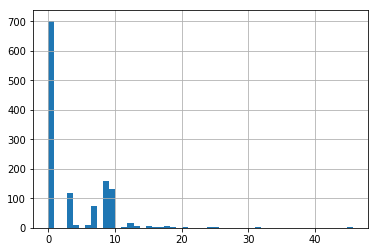

In [18]:
blankframe = pd.DataFrame(columns=["Uid"])

indir = os.path.join("..", "Projected_data\\DEMs\\Slope_WGS")  # Using a loop to go over different rasters from different islands
for idx, file in enumerate(os.listdir(indir)):
    if file.endswith(".tif"):
        In_raster = os.path.join(indir, file)
        In_points = osds_path
        new_col_name = "slope_{}".format(idx)       
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)
        blankframe = blankframe.merge(foo, how='outer', on='Uid')

blankframe.set_index("Uid", inplace=True)
blankframe['slope_deg'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

SLOPE = blankframe[["Uid", 'slope_deg']]
SLOPE.to_csv(os.path.join(intermidiate_DataFramesPath, "SLOPE.csv"))
# plot histogram
Hist_and_stats_on_DF(SLOPE, "slope_deg")

## Depth to water 


Average WT_elev_m is 1.826820172134965
Max WT_elev_m is 85.9987258911
Min WT_elev_m is -0.539620876312


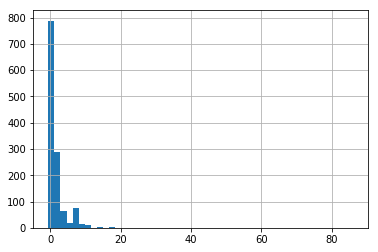

In [19]:
blankframe = pd.DataFrame(columns=["Uid"])
indir = os.path.join("..", "Projected_data\\Water_table\\Tiffs")

for idx, file in enumerate(os.listdir(indir)):     # Using a loop to go over different rasters from different islands
    if file.endswith(".tif"):
        In_raster = os.path.join(indir, file)
        In_points = osds_path
        new_col_name = "WT_elev_m_{}".format(idx)
         
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)   
        # Merge the different islands together 
        blankframe = blankframe.merge(foo, how='outer', on='Uid')

blankframe.set_index("Uid", inplace=True)
blankframe['WT_elev_m'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

WT_ELEV = blankframe[["Uid", 'WT_elev_m']]
WT_ELEV.to_csv(os.path.join(intermidiate_DataFramesPath, "WT_ELEV.csv"))
# plot histogram
Hist_and_stats_on_DF(WT_ELEV, "WT_elev_m")

### Land Surface elevations
This relies on first getting data from lidar dem (1m resolution), then if no data get data from the course (10m) resolution ones to create cohesive dataset

- Worst data downloading experience ever was the lame 10m dem  
- https://pae-paha.pacioos.hawaii.edu/erddap/griddap/usgs_dem_10m_molokai.html

##### Very long run time

working on MokaiWGS.tif
working on MoKaiLiDar.tif
Average Elevation_m is 105.06972144114941
Max Elevation_m is 489.090393066
Min Elevation_m is -0.605226397514


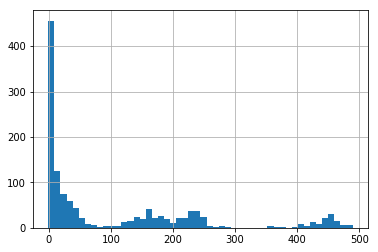

In [20]:
blankframe = pd.DataFrame(columns=["Uid"])
indir_crap = os.path.join("..", "Projected_data\\DEMs\\10mDEM_WGS")

for idx, file in enumerate(os.listdir(indir_crap)):   # Using a loop to go over different rasters from different islands
    if file.endswith(".tif"):
        print("working on {}".format(file))
        In_raster = os.path.join(indir_crap, file)
        In_points = osds_path
        # Define new collumn name you want
        new_col_name = "CrapElev_m_{}".format(idx)
        
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)   
        # Merge the different islands together 
        blankframe = blankframe.merge(foo, how='outer', on='Uid')
        
blankframe.set_index("Uid", inplace=True)
blankframe['CrapElev'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

ELEV_crap = blankframe[["Uid", 'CrapElev']]


####  Now do the same for the lidar dataset  to stitch on ####
blankframe = pd.DataFrame(columns=["Uid"])
indir_good = os.path.join("..", "Projected_data\\DEMs\\Lidar_DEM")

for idx, file in enumerate(os.listdir(indir_good)):   # Using a loop to go over different rasters from different islands
    if file.endswith(".tif"):
        print("working on {}".format(file))
        In_raster = os.path.join(indir_good, file)
        In_points = osds_path
        # Define new collumn name you want
        new_col_name = "LidarElev_m"
        
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)   
        # Merge the different islands together 
        blankframe = blankframe.merge(foo, how='outer', on='Uid')

blankframe.set_index("Uid", inplace=True)
blankframe['LidarElev'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

ELEV_good = blankframe[["Uid", 'LidarElev']]

# Now Merge Elevations to create a master elevation
Master = OSDS.copy()

Master = Master.merge(ELEV_good, on="Uid", how="left")
Master = Master.merge(ELEV_crap, on="Uid", how="left")

Master['Elevation_m'] = Master['LidarElev']

Master['Elevation_m'] = np.where((Master['LidarElev'].isnull()),   #Identifies the case to apply to 
                           Master['CrapElev'],      #This is the value that is inserted
                           Master['Elevation_m'])      #This is the column that is affected

ELEVATION = Master[["Uid", 'Elevation_m']]
ELEVATION.to_csv(os.path.join(intermidiate_DataFramesPath, "ELEVATION.csv"))

Hist_and_stats_on_DF(ELEVATION, "Elevation_m")

### Calculate Depth to Water for all OSDS points

Average Dep_to_Water_m is 104.02674673632629
Max Dep_to_Water_m is 481.590600967
Min Dep_to_Water_m is 0.05757802724800004


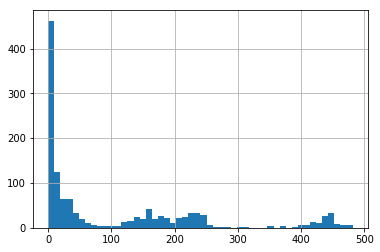

In [21]:
DtoWater = WT_ELEV.merge(ELEVATION, on="Uid", how='outer')                     # merge elevation and WT elevation
DtoWater['Dep_to_Water_m'] = DtoWater['Elevation_m'] - DtoWater['WT_elev_m']   # find the difference 

DtoWater['Dep_to_Water_m'][DtoWater['Dep_to_Water_m'] < 0] = 0.999        # Where it is negative assign value of .999

DTOWATER = DtoWater.copy()
DTOWATER.to_csv(os.path.join(intermidiate_DataFramesPath, "DTOWATER.csv"))

Hist_and_stats_on_DF(DTOWATER, "Dep_to_Water_m")

# Combination, horizontal + Vertical SLR effects


## Check if inside SLR zone 2030

In [23]:
# Compile systems affected by Vertical SLR inundation
Vertical_SLR_2030 = DTOWATER[DTOWATER['Dep_to_Water_m'] < 4.9]
print("vertical stats"); print_stats_on_bool_layers(Vertical_SLR_2030)

# Compile systems in the horizontal surface flood zone
In_polygons = os.path.join("..", "Projected_data/SLR", 'hi_tt_all_slrxa_2030_prj.shp')
new_col_name = 'InSLR2030'
In_points = osds_path
Hor_SLR_2030 = Find_points_inside_polys(In_points, In_polygons, new_col_name)
print("Hor stats"); print_stats_on_bool_layers(Hor_SLR_2030)

SLR_2030_yes = Vertical_SLR_2030.merge(Hor_SLR_2030, on="Uid", how="outer")
SLR_2030_yes = SLR_2030_yes[['Uid', new_col_name]]
SLR_2030_yes[new_col_name] = True   # be sure to set all the rows that are in hor or vert zone to true

SLR_2030_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "SLR_2030_yes.csv"))
print("Vert+Hor stats"); print_stats_on_bool_layers(SLR_2030_yes)

vertical stats
number of affected points = 350
number of total systems = 1280
percent of systems affected = 0.2734375
Hor stats
number of affected points = 1
number of total systems = 1280
percent of systems affected = 0.00078125
Vert+Hor stats
number of affected points = 351
number of total systems = 1280
percent of systems affected = 0.27421875


### Check if inside SLR zone 2050 


In [24]:
# Compile systems affected by Vertical SLR inundation
Vertical_SLR_2050 = DTOWATER[DTOWATER['Dep_to_Water_m'] < 5.5]
print("vertical stats"); print_stats_on_bool_layers(Vertical_SLR_2050)

# Compile systems in the horizontal surface flood zone
In_polygons = os.path.join("..", "Projected_data/SLR", 'hi_tt_all_slrxa_2050_prj.shp')
new_col_name = 'InSLR2050'
In_points = osds_path
Hor_SLR_2050 = Find_points_inside_polys(In_points, In_polygons, new_col_name)
print("Hor stats"); print_stats_on_bool_layers(Hor_SLR_2050)

SLR_2050_yes = Vertical_SLR_2050.merge(Hor_SLR_2050, on="Uid", how="outer")
SLR_2050_yes = SLR_2050_yes[['Uid', new_col_name]]
SLR_2050_yes[new_col_name] = True  # be sure to set all the rows that are in hor or vert zone to true

SLR_2050_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "SLR_2050_yes.csv"))
print("Vert+Hor stats"); print_stats_on_bool_layers(SLR_2050_yes)

vertical stats
number of affected points = 359
number of total systems = 1280
percent of systems affected = 0.28046875
Hor stats
number of affected points = 3
number of total systems = 1280
percent of systems affected = 0.00234375
Vert+Hor stats
number of affected points = 360
number of total systems = 1280
percent of systems affected = 0.28125


### Check if inside SLR zone 2100

In [25]:
# Compile systems affected by Vertical SLR inundation
Vertical_SLR_2100 = DTOWATER[DTOWATER['Dep_to_Water_m'] < 7.6]
print("vertical stats"); print_stats_on_bool_layers(Vertical_SLR_2100)


In_polygons = os.path.join("..", "Projected_data/SLR", 'hi_tt_all_slrxa_2100_prj.shp')
new_col_name = 'InSLR2100'
In_points = osds_path
Hor_SLR_2100 = Find_points_inside_polys(In_points, In_polygons, new_col_name)
print("Hor stats"); print_stats_on_bool_layers(Hor_SLR_2100)

SLR_2100_yes = Vertical_SLR_2100.merge(Hor_SLR_2100, on="Uid", how="outer")
SLR_2100_yes = SLR_2100_yes[['Uid', new_col_name]]
SLR_2100_yes[new_col_name] = True    # be sure to set all the rows that are in hor or vert zone to true

SLR_2100_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "SLR_2100_yes.csv"))
print("Vert+Hor stats"); print_stats_on_bool_layers(SLR_2100_yes)

vertical stats
number of affected points = 423
number of total systems = 1280
percent of systems affected = 0.33046875
Hor stats
number of affected points = 75
number of total systems = 1280
percent of systems affected = 0.05859375
Vert+Hor stats
number of affected points = 425
number of total systems = 1280
percent of systems affected = 0.33203125


## Calculate OSDS Density 

Average OSDS_Density_perAcre is 0.3477778187458932
Max OSDS_Density_perAcre is 1.5660881996200002
Min OSDS_Density_perAcre is 0.00991195067763


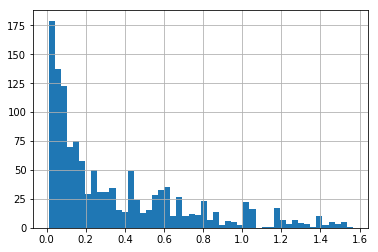

In [26]:
# Project the OSDS dots into UTM4n to get units of meters
input_features = os.path.join("..", "Projected_data/OSDS_v6_Exploded/", 'CESSPOOLSv6_Exploded.shp')
OSDS_utm_path = os.path.join(tempspace, "ClassIV_cespool_UTM4N.shp" )  # replacing "..", "Projected_data/OSDS/UTM", "ClassIV_cespool_UTM4N.shp"
out_coordinate_system = arcpy.SpatialReference('WGS 1984 UTM Zone  4N')
arcpy.Project_management(input_features, OSDS_utm_path, out_coordinate_system)

# Density Parameters
effect_distance_m = 360.5
Density_units = "ACRES"
cellSize = 64     
new_col_name = "OSDS_Density_perAcre"   # Define new collumn name you want

# internal parameters
myNbrCirc = NbrCircle(effect_distance_m, "MAP")
populationField = "NONE"
# Run density algo
outPdens = PointDensity(OSDS_utm_path, populationField, cellSize, myNbrCirc, Density_units)
outPdens.save(os.path.join(tempspace, 'CessPool_density.tif'))

# Convert format to dataframe
In_raster = outPdens
In_points = osds_path
ExtractValuesToPoints(In_points, In_raster, os.path.join(tempspace, "test_rain_OSDS.shp"))

# read on OSDS data from shapefile into dataframe 
extracted_points_path = os.path.join(tempspace, "test_rain_OSDS.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))


#Select only selected columns
want_cols = ['Uid', 'RASTERVALU']
Extract_frame = Extracted_All[want_cols]
Extract_frame.rename(columns={'RASTERVALU':new_col_name}, inplace=True)     # Rename to col that you want
Extract_frame.loc[Extract_frame[new_col_name] < 0] = np.nan                 # Deal with the -9999 values set to nan

OSDS_DENSITY = Extract_frame.copy()
OSDS_DENSITY.to_csv(os.path.join(intermidiate_DataFramesPath, "OSDS_DENSITY.csv"))

Hist_and_stats_on_DF(OSDS_DENSITY, "OSDS_Density_perAcre")

## Import the Coastal Endpoint ID's from the Bob Model flowpaths

In [62]:
# Read Fliker_ID from the grid cells for each point
In_polygons = os.path.join("..", "Projected_data/ImpactZones_Flik_ID", 'Molokai_grid_w_Flikr_IDs_MauiID.shp')
In_points = osds_path

# Do the spatial join
arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(tempspace, "test_join_pt_2_poly.shp"))

# Sub in the geographically closest Flikr cell if the OSDS didnt hit a GMS grid cell. and format the Final dataframe
in_features = os.path.join(tempspace, "test_join_pt_2_poly.shp")
Flikr_cells = os.path.join("..", "Projected_data/ImpactZones_Flik_ID/GeographicFlikr_data", "Flikr_MoKai_250_cells_wMidpoints.shp")
OSDS_FLIK_ID = deal_with_no_FlikrCellsOSDS_pts(in_features, Flikr_cells)

OSDS_FLIK_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "OSDS_FLIK_ID.csv"))

print_costal_endpoint_flik_ID_analytics(OSDS_FLIK_ID, OSDS)

There are 1280 points with Flikr_IDs
There are 1280 OSDS shp points
There are 0 OSDS units in OSDS, that do not have a flikr cell
There are 0 units with a Flikr cell, but are not in the OSDS file


## Add visitation level from associated Flikr cell 


Average UserDays is 2.9265625
Max UserDays is 29
Min UserDays is 0


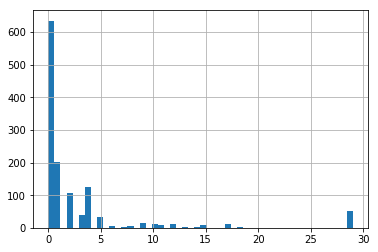

In [39]:
# NOTE this uses OSDS_FLIK_ID (the OSDS Uid to Flik ID key) from above

paths_path = os.path.join("..", "Projected_data/Coast_Usage_Flikr/Processed", 'Statewide_flikr_visitation.shp')
columns_nams = [field.name for field in arcpy.ListFields(paths_path)]
columns_nams.pop(1)  # remove stupid shape col
temparr = arcpy.da.FeatureClassToNumPyArray(paths_path, columns_nams)
tempdf =  pd.DataFrame(temparr)
carelist = ['Flikr_ID', 'UserDays']  # cut to only wanted cols
Flk_userTemp = tempdf[carelist].copy()

# Do the merge with flikrcells
usedays_merge = OSDS_FLIK_ID.merge(Flk_userTemp, on='Flikr_ID', how='left')
carelist2 = ['Uid', 'UserDays']  # cut to only wanted cols

USERDAYS = usedays_merge[carelist2]
USERDAYS.to_csv(os.path.join(intermidiate_DataFramesPath, "USERDAYS.csv"))

Hist_and_stats_on_DF(USERDAYS, "UserDays")

## Lifeguard towers / swim beaches
There are no lifeguard towers on Molokai. 
This shapefile was generated through searching websites that recommended beaches to swim, specifically the official HI tourism website: https://www.gohawaii.com/islands/molokai/things-to-do/beaches was used along with Visit Molokai https://visitmolokai.com/wp/molokai-beaches/ 

In [40]:
# input datasets
Flik_dots_path = os.path.join("..", "Projected_data/ImpactZones_Flik_ID/GeographicFlikr_data", 'State_Gridded_Coast_WGS84_pts.shp')
variable_pts_path = os.path.join("..", "Projected_data/Swim_beaches", 'Molokai_Swim_Beaches.shp')

# make silly arc layers
arcpy.MakeFeatureLayer_management (Flik_dots_path, "Flik_dots")
arcpy.MakeFeatureLayer_management (variable_pts_path, "variable_pts")

# Select Flik cells(dots) by proximity to LG towers
Selection = arcpy.SelectLayerByLocation_management("Flik_dots", "WITHIN_A_DISTANCE", "variable_pts", "550 meters", "NEW_SELECTION","NOT_INVERT")
arcpy.CopyFeatures_management(Selection, os.path.join(tempspace, "selected_variables.shp"))

# read data from shapefile 
extracted_points_path = os.path.join(tempspace, "selected_variables.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))

# Cut out unneded columns and save final dataframe  (Note that the tempframe contains the actual flikr_ID of the guard station for each)
want_cols = ['Uid', 'Swim_beach']
tempframe = Extracted_All.merge(OSDS_FLIK_ID, on="Flikr_ID", how="left")
tempframe["Swim_beach"] = True
SWIM_BEACHES = tempframe[want_cols]
SWIM_BEACHES.to_csv(os.path.join(intermidiate_DataFramesPath, "SWIM_BEACHES.csv"))

# print analysics on how OSDS file from top cell, matches up with results
print("There are {} points draining to swim beaches".format(len(SWIM_BEACHES)))
print("There are {} OSDS shp points".format(len(OSDS)))

There are 136 points draining to swim beaches
There are 1280 OSDS shp points


## Coastal Ecosystem impact valuations from Marine Biology Group


Average Coral_rank is 2.0
Max Coral_rank is 2
Min Coral_rank is 2


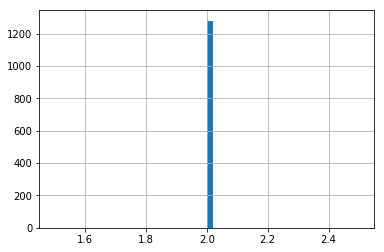

In [69]:
# Add here 
coral_merge = OSDS_FLIK_ID.copy()
coral_merge['Coral_rank'] = 2

carelist2 = ['Uid', 'Coral_rank']  # cut to only wanted cols

CORAL = coral_merge[carelist2]
CORAL.to_csv(os.path.join(intermidiate_DataFramesPath, "CORAL.csv"))

Hist_and_stats_on_DF(CORAL, "Coral_rank")

Average Coral_rank is 2.0
Max Coral_rank is 2
Min Coral_rank is 2


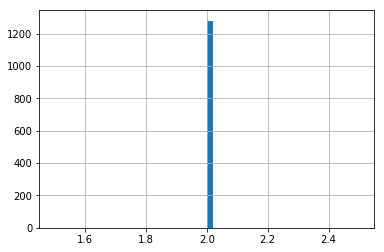

In [76]:
# Add REAL CODE here 


# Dummy code
coral_merge = OSDS_FLIK_ID.copy()
coral_merge['Coral_rank'] = 2

carelist2 = ['Uid', 'Coral_rank']  # cut to only wanted cols

CORAL = coral_merge[carelist2]
CORAL.to_csv(os.path.join(intermidiate_DataFramesPath, "CORAL.csv"))

Hist_and_stats_on_DF(CORAL, "Coral_rank")

Average RFish_rank is 2.0
Max RFish_rank is 2
Min RFish_rank is 2


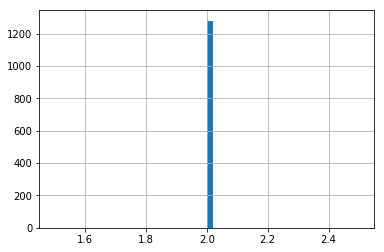

In [77]:
# Add REAL CODE here 


# Dummy code
fish_merge = OSDS_FLIK_ID.copy()
fish_merge['RFish_rank'] = 2

carelist2 = ['Uid', 'RFish_rank']  # cut to only wanted cols

FISH = fish_merge[carelist2]
FISH.to_csv(os.path.join(intermidiate_DataFramesPath, "FISH.csv"))

Hist_and_stats_on_DF(FISH, "RFish_rank")

# Ocean Circulation proxy
##### Wave Power (in KW/m) Long-term Mean, 2000-2013 – Statewide

Average Wave_pwr is 8.502659989743076
Max Wave_pwr is 31.0620708466
Min Wave_pwr is 0.150198996067


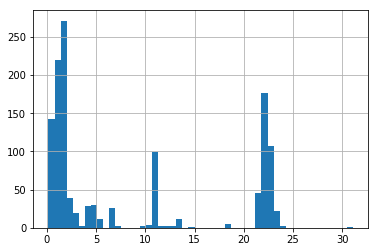

In [42]:
paths_path = os.path.join("..", "Projected_data/Coastal_Circulation", 'Wave_power_KWm_Flikr_pts.shp')
columns_nams = [field.name for field in arcpy.ListFields(paths_path)]
columns_nams.pop(1)  # remove stupid shape col
temparr = arcpy.da.FeatureClassToNumPyArray(paths_path, columns_nams)
tempdf =  pd.DataFrame(temparr)

carelist = ['Flikr_ID', 'Wave_pwr']  # cut to only wanted cols
Flk_OcircTemp = tempdf[carelist].copy()

# Do the merge with flikrcells for corals
Ocirc_merge = OSDS_FLIK_ID.merge(Flk_OcircTemp, on='Flikr_ID', how='left')
carelist2 = ['Uid', 'Wave_pwr']  # cut to only wanted cols

WAVE_POWER = Ocirc_merge[carelist2]
WAVE_POWER.to_csv(os.path.join(intermidiate_DataFramesPath, "WAVE_POWER.csv"))

Hist_and_stats_on_DF(WAVE_POWER, "Wave_pwr")

# Consolidation into different areas and association of metadata

## Add Census Track IDs


In [43]:
# Create the key to join OSDS points to Census blocks 
In_polygons = os.path.join("..", "Projected_data/Census", '2010_Census_Tracts_Clean.shp')
In_points = osds_path
want_cols = ['Uid', 'Track_ID']
Level = 'Tracts'

TRACK_ID = Census_data_joining(In_points, In_polygons, want_cols, Save_meta=True, Level=Level)
TRACK_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "TRACK_ID.csv"))

## Add census block group IDs 


In [44]:
# Create the key to join OSDS points to Census blockgroups
In_polygons = os.path.join("..", "Projected_data/Census", '2010_Census_Block_Groups_Clean.shp')
In_points = osds_path
want_cols = ['Uid', 'BlockGp_ID']
Level = 'Block_Groups'

BLOCKGROUP_ID = Census_data_joining(In_points, In_polygons, want_cols, Save_meta=True, Level=Level)
BLOCKGROUP_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "BLOCKGROUP_ID.csv"))

## Add census block IDs 

In [45]:
# Create the key to join OSDS points to Census blocks 
In_polygons = os.path.join("..", "Projected_data/Census", '2010_Census_Blocks_Clean.shp')
In_points = osds_path
want_cols = ['Uid', 'BlockBk_ID']
Level = 'Blocks'

BLOCK_ID = Census_data_joining(In_points, In_polygons, want_cols, Save_meta=True, Level=Level)
BLOCK_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "BLOCK_ID.csv"))

## Label if point is within a 2017 cesspool priority zone
Should be none for Molokai as there dont seem to be any 2017 priority zones there 

In [47]:
In_polygons = os.path.join("..", "Projected_data/Old_2017_priority_areas", 'Old_2017_priority_areas.shp')
new_col_name = 'In_2017_CP_zone'
In_points = osds_path

IN_2017_CP = Find_points_inside_polys(In_points, In_polygons, new_col_name)
IN_2017_CP.to_csv(os.path.join(intermidiate_DataFramesPath, "IN_2017_CP.csv"))

print_stats_on_bool_layers(IN_2017_CP)

number of affected points = 0
number of total systems = 1280
percent of systems affected = 0.0


# Merge together all factors


In [79]:
mergeframes_list = [BLOCK_ID, BLOCKGROUP_ID, TRACK_ID, OSDS_FLIK_ID, USERDAYS, SWIM_BEACHES,
                    COASTLINE, MUN_WELLS, DOM_WELLS, STREAMS, SOILS_NRCS, RAINFALL,  SLOPE, OSDS_DENSITY, WETLANDS,
                    DTOWATER, SLR_2030_yes, SLR_2050_yes, SLR_2100_yes, WellCZ_B_yes, WellCZ_C_yes, 
                    FISH, CORAL, IN_2017_CP, WAVE_POWER]  # ELEVATION  # PPL_PER_HOS,


 
# Print out specs on the different lists
for i in mergeframes_list: 
    print(f"{i.columns}, length = {len(i)}")   

# Merge dataframes into master
OSDS_Master = OSDS.copy()
for i in mergeframes_list:
    OSDS_Master = OSDS_Master.merge(i, on="Uid", how="left")

# Some post processing 
OSDS_Master["dist2_Strm_Wtlnd_m"] = OSDS_Master[["dist2_Streams_m", "dist2_Wetlands_m"]].min(axis=1)
OSDS_Master.drop_duplicates(subset=['Uid'], keep="first", inplace=True)

OSDS_Master.to_csv(os.path.join(".", "Outputs/OSDS_Dots", 'OSDS_MASTER_RiskFactors_v6.csv'), index =False)
print("total length is {}".format(len(OSDS_Master)))

Index(['Uid', 'BlockBk_ID'], dtype='object'), length = 1280
Index(['Uid', 'BlockGp_ID'], dtype='object'), length = 1280
Index(['Uid', 'Track_ID'], dtype='object'), length = 1280
Index(['Uid', 'Flikr_ID', 'Flikr_X', 'Flikr_Y'], dtype='object'), length = 1280
Index(['Uid', 'UserDays'], dtype='object'), length = 1280
Index(['Uid', 'Swim_beach'], dtype='object'), length = 136
Index(['Uid', 'dist2_coast_m'], dtype='object'), length = 1280
Index(['Uid', 'dist2_MunWells_m'], dtype='object'), length = 1280
Index(['Uid', 'dist2_DomWells_m'], dtype='object'), length = 1280
Index(['Uid', 'dist2_Streams_m'], dtype='object'), length = 1280
Index(['Uid', 'nrcs_DtoBrock', 'nrcs_FloodFreq', 'nrcs_septic_dominant',
       'nrcs_septic_least', 'nrcs_septic_most', 'nrcs_ksat_hi', 'nrcs_ksat_lo',
       'nrcs_ksat_rep', 'nrcs_rockFrag3in'],
      dtype='object'), length = 1280
Index(['Uid', 'rainfall_in'], dtype='object'), length = 1280
Index(['Uid', 'slope_deg'], dtype='object'), length = 1274
Index(['Ui

# Ranks and weights 

Ingests the OSDS data with risk factors assigned and develops the **risk-factor scores** as well as applying **weights** to each parameter to develop a final **prioritization score.**

In [80]:
# Read in initial thresholds off of csv
thresholds =   pd.read_csv(os.path.join("..", "Projected_data", 'Thresholds_and_Weights_v7_expWeight.csv'), index_col=0)
numcols=['W1_base', 'W2_eco', 'W3_anthro', 'T1', 'T2', 'T3']
thresholds[numcols] = thresholds[numcols].apply(pd.to_numeric, errors='coerce', axis=1)

In [81]:
# Load datastets
OSDS_Master = pd.read_csv(os.path.join("Outputs/OSDS_Dots", 'OSDS_MASTER_RiskFactors_v6.csv'))
OSDS_Master.drop_duplicates(subset=['Uid'], keep="first", inplace=True)
baseCols = ['X', 'Y', 'Island', 'TMK', 'Uid', 'In_2017_CP_zone',
             'BlockBk_ID', 'BlockGp_ID', 'Track_ID', 'Flikr_ID']  # 'PepPerHos'
priority_master = OSDS_Master[baseCols].copy()


# Identify variables to consider and rank
Rank_Cols = ['Soil_Suitability_Rank',  'SLR_Rank', 'WELLCZ_Rank', 'dist2_coast_m_Rank', 
             'dist2_Strm_Wtlnd_m_Rank', 'rainfall_in_Rank', 'dist2_MunWells_m_Rank', 
             'dist2_DomWells_m_Rank', 'Dep_to_Water_m_Rank', 'OSDS_Density_perAcre_Rank',
             'Swim_beach_Rank', 'UserDays_Rank', 'Fish_Rank', 'Coral_Rank', 'Wave_pwr_Rank']  # , 'PepPerHos_Rank'

In [82]:
# Deal with some naming issues
OSDS_Master['nrcs_ksat_rep_slowwater'] = OSDS_Master['nrcs_ksat_rep'].copy()
OSDS_Master['nrcs_ksat_rep_filtering'] = OSDS_Master['nrcs_ksat_rep'].copy()
OSDS_Master['nrcs_ksat_rep_bottomseepage'] = OSDS_Master['nrcs_ksat_rep'].copy()

## Create a consolidated soil suitability rank that takes into consideration: 
- Depth to Bedrock or Cemented Pan  100%       
- Flooding or Ponding               100%  
- Filtering Capacity (ft/d)         100% 
- Slow Water Movement (ft/d)        100% 
- Seepage From Bottom Layer (ft/d)  33%
- Slope (percent)                   33% 
- Percent Rock Fragments > 3”       33%   

In [83]:
# create a Soil suitability rank, with all 7 parameters equally weighted  ( high values = LEAST SUITABLE)

plist =  ['nrcs_ksat_rep_slowwater', 'nrcs_DtoBrock', 'nrcs_ksat_rep_filtering', 
          'nrcs_ksat_rep_bottomseepage', 'slope_deg', 'nrcs_rockFrag3in']

# Prioritize thresholded ones
framedic_Soil_temp = {}
for idx, col in enumerate(plist):
    Ty, T1, T2, T3 = read_3_thresholds(thresholds, col)
    framedic_Soil_temp["Rank_{}".format(col)] = cut_by_three_numeric_thresholds(OSDS_Master, col, Ty, T1, T2, T3)
    
    # Soil Type Flood Frequency 
FLOOD_FREQ = OSDS_Master[["Uid", 'nrcs_FloodFreq']].copy()
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "None", 'nrcs_FloodFreq_Rank'] = "P4"
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "Rare", 'nrcs_FloodFreq_Rank'] = "P3"
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "Occasional", 'nrcs_FloodFreq_Rank'] = "P2"
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "Frequent", 'nrcs_FloodFreq_Rank'] = "P1"
framedic_Soil_temp["Rank_nrcs_FloodFreq"] = FLOOD_FREQ[["Uid", 'nrcs_FloodFreq_Rank']]

# Change out the P values with numeric values
for key in framedic_Soil_temp.keys():
    framedic_Soil_temp[key].replace(to_replace = "P1", value = 99, inplace = True)
    framedic_Soil_temp[key].replace(to_replace = "P2", value = 66, inplace = True)
    framedic_Soil_temp[key].replace(to_replace = "P3", value = 33, inplace = True)
    framedic_Soil_temp[key].replace(to_replace = "P4", value = 1, inplace = True)
    
# Merge dataframes into master
SOIL_MASTER = priority_master.copy()
for i in framedic_Soil_temp.keys():
    SOIL_MASTER = SOIL_MASTER.merge(framedic_Soil_temp[i], on="Uid", how="left")   
    
# This contains the internal weightings for the soil suitability rank
Prioritization_vars_dic = {
    'nrcs_ksat_rep_slowwater_Rank':1,
    'nrcs_ksat_rep_bottomseepage_Rank':0.33,
    'nrcs_ksat_rep_filtering_Rank':1,
    'nrcs_DtoBrock_Rank':1,
    'nrcs_FloodFreq_Rank':1,
    'slope_deg_Rank':0.33,
    'nrcs_rockFrag3in_Rank':0.33  }

# Run the interlal weightings for the suitibility rank
for var in Prioritization_vars_dic.keys():
    SOIL_MASTER[var] = SOIL_MASTER[var]*Prioritization_vars_dic[var]

SOIL_MASTER['Soil_Suitability_Rank'] = SOIL_MASTER[list(Prioritization_vars_dic.keys())].mean(axis=1)
# Save the consolidated soil rank by itself
SOIL_MASTER = SOIL_MASTER[['Uid', 'Soil_Suitability_Rank']]

## Prioritization Function: Threshold then 1d-convective dispersive decay: 100 pt scale

In [84]:
# Threshold then exponential decay
def threshold_then_decay(OSDS_df, col_name, T1, ascending):
    # reminder, 100 is bad/more impactful, 0 is good/least impactful
    
    return_frame = OSDS_df[["Uid", col_name]].copy()
    
    scaler = return_frame[col_name].median()*.1   # this scale factor controls the shape of the exponential decay and essentially revises the value at which scores transition from high (90s and above) to lower
    #print("for {} scaler is {}".format(col_name, scaler))
    
    if ascending == True:
        return_frame.loc[return_frame[col_name] < T1, '{}_Rank'.format(col_name)] = 100
        return_frame.loc[return_frame[col_name] > T1, '{}_Rank'.format(col_name)] = 100*((T1+scaler)/(return_frame[col_name]+scaler))
       
        
    if ascending == False:
        return_frame.loc[return_frame[col_name] > T1, '{}_Rank'.format(col_name)] = 100
        return_frame.loc[return_frame[col_name] < T1, '{}_Rank'.format(col_name)] = 100*(return_frame[col_name]+scaler)/(T1+scaler)

    return_frame = return_frame[["Uid",'{}_Rank'.format(col_name)]]
    
    return return_frame 


# a 0 to 100 scaler function
def MY_minmaxscaler_dfCol(col, reverse=False):   
    # Reverse True indicates that bigger data values   (e.g dist to coast) get smaller ranks meaning less impact 
    # Reverse False indicates that smaller data values (e.g OSDS_density)  get smaller ranks meaning less impact  
    
    mx = col.max()
    mn = col.min()   
    if reverse==False:
        scaled_series = 100*(col-mn)/(mx-mn)       
    if reverse==True:
        scaled_series = 100*(col-mx)/(mn-mx)
    
    return scaled_series

In [85]:
framedic_decay = {}

# Loop over the non-soil parameters and add their ranks to the dic
plist_ascending =  ['dist2_coast_m', 'dist2_Strm_Wtlnd_m', 'dist2_MunWells_m',
                    'dist2_DomWells_m', 'Dep_to_Water_m', 'rainfall_in', 'Wave_pwr'] 
plist_decending =  ['OSDS_Density_perAcre', 'UserDays']

for idx, col in enumerate(plist_ascending):
    Ty, T1, T2, T3 = read_3_thresholds(thresholds, col)
    framedic_decay["Rank_{}".format(col)] = threshold_then_decay(OSDS_Master, col, T1, ascending=True)

for idx, col in enumerate(plist_decending):
    Ty, T1, T2, T3 = read_3_thresholds(thresholds, col)
    framedic_decay["Rank_{}".format(col)] = threshold_then_decay(OSDS_Master, col, T1, ascending=False) 

In [86]:
# Add in the non-loopable (thresholded) parameters to the framedic

# Add the soil ranking
framedic_decay['SOIL_MASTER'] = SOIL_MASTER

# Sea Level Rise  'InSLR2030', 'InSLR2050',  'InSLR2100'
SLR = OSDS_Master[["Uid", 'InSLR2030', 'InSLR2050',  'InSLR2100']].copy()
SLR['SLR_Rank'] = 0
SLR.loc[SLR['InSLR2100'] == True, 'SLR_Rank'] = 33
SLR.loc[SLR['InSLR2050'] == True, 'SLR_Rank'] = 66
SLR.loc[SLR['InSLR2030'] == True, 'SLR_Rank'] = 100
framedic_decay["Rank_SLR"] = SLR[["Uid", 'SLR_Rank']]

# Well Capture Zones
WELLCZs = OSDS_Master[["Uid", 'In_WellCZ_B', 'In_WellCZ_C']].copy()
WELLCZs['WELLCZ_Rank'] = 0
WELLCZs.loc[WELLCZs['In_WellCZ_C'] == True, 'WELLCZ_Rank'] = 50
WELLCZs.loc[WELLCZs['In_WellCZ_B'] == True, 'WELLCZ_Rank'] = 100
framedic_decay["Rank_WELLCZ"] = WELLCZs[["Uid", 'WELLCZ_Rank']]

# Swim beaches
SWIMBEACH = OSDS_Master[["Uid", 'Swim_beach']].copy()
SWIMBEACH['Swim_beach_Rank'] = 0
SWIMBEACH.loc[SWIMBEACH['Swim_beach'] == True, 'Swim_beach_Rank'] = 100
framedic_decay["Rank_Swim_beach"] = SWIMBEACH[["Uid", 'Swim_beach_Rank']]

# Fish   # Note that the original col was named RFish_rank with a small r the Fish_Rank with big R is the 0-100 score
FISHY = OSDS_Master[["Uid", 'RFish_rank']].copy()
FISHY['Fish_Rank'] = 0
FISHY.loc[FISHY['RFish_rank'] == 1, 'Fish_Rank'] = 100
FISHY.loc[FISHY['RFish_rank'] == 2, 'Fish_Rank'] = 66
FISHY.loc[FISHY['RFish_rank'] == 3, 'Fish_Rank'] = 33
FISHY.loc[FISHY['RFish_rank'] == 4, 'Fish_Rank'] = 0
framedic_decay["Rank_Fish"] = FISHY[["Uid", 'Fish_Rank']]

# Coral    Note that the original col was named Coral_rank with a small r the Coral_Rank with big R is the 0-100 score
CORALY = OSDS_Master[["Uid", 'Coral_rank']].copy()
CORALY['Coral_Rank'] = 0
CORALY.loc[CORALY['Coral_rank'] == 1, 'Coral_Rank'] = 100
CORALY.loc[CORALY['Coral_rank'] == 2, 'Coral_Rank'] = 66
CORALY.loc[CORALY['Coral_rank'] == 3, 'Coral_Rank'] = 33
CORALY.loc[CORALY['Coral_rank'] == 4, 'Coral_Rank'] = 0
framedic_decay["Rank_Coral"] = CORALY[["Uid", 'Coral_Rank']]


# Add number of people per household
####Pep_hos = OSDS_Master[["Uid", 'PepPerHos']].copy()
####Pep_hos['PepPerHos_Rank'] = MY_minmaxscaler_dfCol(OSDS_Master['PepPerHos'], reverse=False)
####framedic_decay["Rank_PepPerHos"] = Pep_hos[["Uid", 'PepPerHos_Rank']]

1280


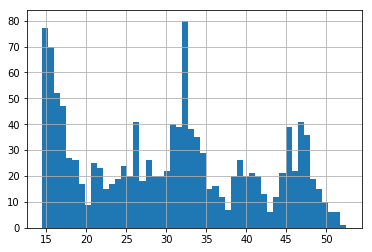

In [87]:
# Merge dataframes into master
DECAY_PRIORITY_MASTER = priority_master.copy()
for i in framedic_decay.keys():
    DECAY_PRIORITY_MASTER = DECAY_PRIORITY_MASTER.merge(framedic_decay[i], on="Uid", how="left")

# Create the single mean rank
DECAY_PRIORITY_MASTER['Priority_mean'] = DECAY_PRIORITY_MASTER[Rank_Cols].mean(axis=1)

print(len(DECAY_PRIORITY_MASTER))
DECAY_PRIORITY_MASTER['Priority_mean'].hist(bins=50)

#Print out a copy to use in the sensitivity testing notebook
DECAY_PRIORITY_MASTER.to_csv(os.path.join(tempspace, "DECAY_PRIORITY_MASTER.csv"), index=False)

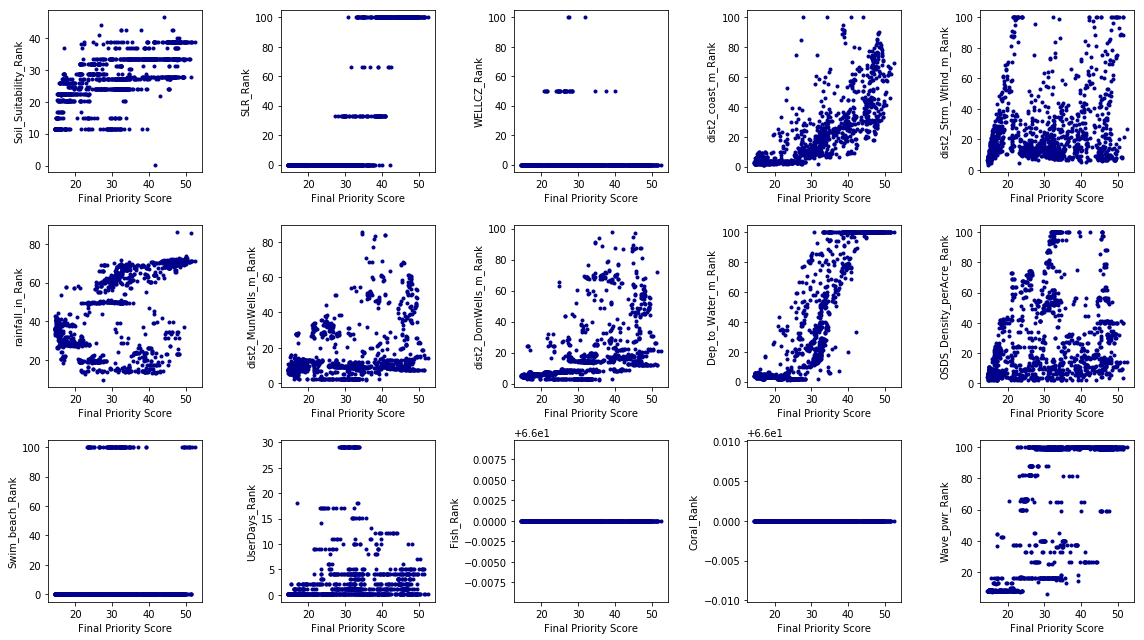

In [88]:
# Plot the comparison between individual risk factor scores and the final priority score.  
fig, ax = plt.subplots(3,5, figsize=(16, 9))
for idx, col in enumerate(Rank_Cols):
    ax = plt.subplot(3,5,idx+1)
    x = DECAY_PRIORITY_MASTER['Priority_mean']
    y = DECAY_PRIORITY_MASTER[col]
    plt.scatter(x, y, marker=".", color='darkblue')
    plt.ylabel(col); plt.xlabel('Final Priority Score')
    plt.tight_layout()

# Base Scenario each factor Weighted between 1-5 by expert panel 

This framework provides the ability to weigh the influence of each risk factor on the final priority score for each unit. Weighting can be done by multiplying the individual parameter score by a weight value, for example a weight value of two (2) can be used if it is desired for a parameter to be twice as important as those with a weighting value of one (1).


Note, at one point I was scaling the final priority score into 0-100 space for comparisons between scenarios, but this might not be the best idea. used this syntax BASE_PRIORITY_MASTER['Weighted_Priority_mean'] = MY_minmaxscaler_dfCol(BASE_PRIORITY_MASTER['Weighted_Priority_mean'], reverse=False)

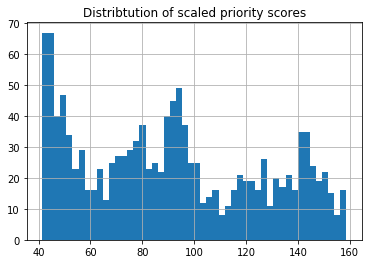

In [89]:
BASE_PRIORITY_MASTER = DECAY_PRIORITY_MASTER[baseCols].copy()  # Create base for weighting

# Apply weights to each column
for i in Rank_Cols: 
    col = i.replace("_Rank", "")
    weight = thresholds.loc[col]['W1_base']
    
    # Average the two methods and apply weights
    BASE_PRIORITY_MASTER[i] = DECAY_PRIORITY_MASTER[i]*weight
    
    
BASE_PRIORITY_MASTER['Weighted_Priority_mean'] = BASE_PRIORITY_MASTER[Rank_Cols].mean(axis=1)

# prepare the final to be able to determine if more than 50% of the OSDS units are in a Priority zone (average wont count NaN as 0)
BASE_PRIORITY_MASTER['In_2017_CP_zone'].fillna(False, inplace=True)

# Plots 
BASE_PRIORITY_MASTER['Weighted_Priority_mean'].hist(bins=50)
plt.title('Distribtution of scaled priority scores')

BASE_PRIORITY_MASTER.to_csv(os.path.join(tempspace, "BASE_PRIORITY_MASTER.csv"))

## Consolidate Individual OSDS units into Census Polygon groups:
Different resolutions include: - 2010 Census Tracks, - 2010 Census Block Groups, - 2010 Census Blocks

This assigns the average final priority score of the OSDS units that fall within each geographic polygon to the census unit. A parameter to exclude units that do not contain some minimum number of OSDS is available to avoid biasing the prioritization by areas with an insignificant number of OSDS units


#####  Also delineate Priority categories (High, Med Low) Categories are defined primarily by our ranking¶
- with top 10% highest priority scores as High
- top 11% to 50% as Medium
- Bottom 50% as low 

Then the zones in the 2017 priority zones are delineated by a +

Therefore the final Priority categories are defined for each census zone (tracks, blocks, block groups) where the average priority score of all of the OSDS units falling into the given geographic area (of those areas where the number of OSDS units is greater than the cutoff (25 for tracks, 20 for block groups, 15 for blocks) is:

- **High Priority +**:  the top 10% of the zone-averaged priority scores that also have 50% or more of their OSDS units falling within a 2017 priority zone. 
- **High Priority**:  the top 10% of the zone-averaged priority scores that do not have 50% or more of their OSDS units falling within a 2017 priority zone.
- **Medium Priority +**:  the middle 40% (50%-10%) of the zone-averaged priority scores that also have 50% or more of their OSDS units falling within a 2017 priority zone.
- **Medium Priority**:  the middle 40% (50%-10%) of the zone-averaged priority scores that do not have 50% or more of their OSDS units falling within a 2017 priority zone.
- **Low Priority +**:  the bottom 50% of the zone-averaged priority scores that do have 50% or more of their OSDS units falling within a 2017 priority zone.
- **Low Priority:**  the bottom 50% of the zone-averaged priority scores that do have 50% or more of their OSDS units falling within a 2017 priority zone.

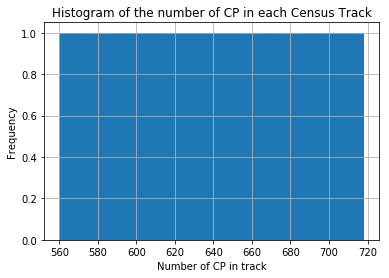

In [92]:
# Consolidate the many CP units into tracks, remembering that the 
UnitCol = 'Track_ID'
Tracks_priority_frame_base = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=25)
Tracks_priority_frame_base['OSDS_count'].hist(bins=len(Tracks_priority_frame_base['OSDS_count'].unique()))
plt.title("Histogram of the number of CP in each Census Track"); plt.xlabel("Number of CP in track"); plt.ylabel("Frequency")

In [95]:
# Cut columns to desired ones 
WantCols = ['Track_ID', 'Final_Prioity_Score','Soil_Suitability_Rank', 'SLR_Rank', 'WELLCZ_Rank',
       'dist2_coast_m_Rank', 'dist2_Strm_Wtlnd_m_Rank', 'rainfall_in_Rank',
       'dist2_MunWells_m_Rank', 'dist2_DomWells_m_Rank', 'Dep_to_Water_m_Rank',
       'OSDS_Density_perAcre_Rank', 'Swim_beach_Rank', 'UserDays_Rank', "Fish_Rank", "Coral_Rank", 'Wave_pwr_Rank',
       'OSDS_count']   # will delete OSDS count once is in name col   #  'PepPerHos_Rank',
 
compare_priority_score_Track = Tracks_priority_frame_base[WantCols]
compare_priority_score_Track = compare_priority_score_Track.sort_values("Final_Prioity_Score", ascending=False)


# Get and set track names to the index
trackpath = os.path.join("..", "Projected_data/Census/With_2017_priority", '2010_Census_Tracts_Meta_w2017.shp') 
Track_meta = get_track_names(trackpath, "Track_ID")  # in the functions file
compare_priority_score_Track = compare_priority_score_Track.merge(Track_meta, on='Track_ID', how='left')
# Add on the # of CPs to the index 
compare_priority_score_Track['Name_ID'] = compare_priority_score_Track['Name_ID']+": CPs="+compare_priority_score_Track['OSDS_count'].astype(str)
compare_priority_score_Track = compare_priority_score_Track.set_index('Name_ID')                                  # Convert to pandas bliss
del compare_priority_score_Track['Track_ID'];  del compare_priority_score_Track['OSDS_count']

# make 
renamas = {'Final_Prioity_Score':'Final Prioity Score', 
            'Soil_Suitability_Rank':'Soil Suitability',
            'SLR_Rank':'Sea Level Rise',
            'WELLCZ_Rank':'Well Capture Zones',
            'dist2_coast_m_Rank':'Dist. to Coast',
            'dist2_Strm_Wtlnd_m_Rank':'Dist. to Strms/Wtlnds',
            'rainfall_in_Rank':'Rainfall',
            'dist2_MunWells_m_Rank':'Dist. to Muni. Wells',
            'dist2_DomWells_m_Rank':'Dist. to Dom. Wells',
            'Dep_to_Water_m_Rank':'Depth to GW',
            'OSDS_Density_perAcre_Rank':'OSDS Density',
            'Swim_beach_Rank':'Swim Beaches',
            'UserDays_Rank':'Coastline Usage',
            'Fish_Rank':'Reef Fishery Priority',
            'Coral_Rank':'Coral Reef Priority', 
            'Wave_pwr_Rank': 'Wave Power'}    # , 'PepPerHos_Rank':'People per House'}

compare_priority_score_Track.rename(columns=renamas, inplace=True)     # Rename to col that you want

In [99]:
compare_priority_score_Track

,Final Prioity Score,Soil Suitability,Sea Level Rise,Well Capture Zones,Dist. to Coast,Dist. to Strms/Wtlnds,Rainfall,Dist. to Muni. Wells,Dist. to Dom. Wells,Depth to GW,OSDS Density,Swim Beaches,Coastline Usage,Reef Fishery Priority,Coral Reef Priority,Wave Power
Name_ID,,,,,,,,,,,,,,,,
: East Moloka'i: T#318: CPs=718,115.007776,60.846099,155.323120,1.462396,124.486780,73.701698,107.464330,87.554432,110.637635,273.86731,148.607086,6.406685,4.582604,198.0,198.0,176.344114
: West Moloka'i: T#295: CPs=560,60.734713,42.531491,2.491071,8.571429,24.822201,67.704747,67.001381,62.692798,21.451707,38.05979,102.112597,29.285714,7.945626,198.0,198.0,40.350147


The island of Molokai contains 1278 cesspools and has a total of 3 census tracts although only 2 tracts contained more than 25 cesspools and were thus categorized with the HCPT. Of these tracts 50% or 1 of them were categorized as high (1) priority (classified as the top 25% of census tracts statewide), 0% or 0 of them were categorized as medium (2) priority and 50% or 1 of them were categorized as low (3) priority. The total number of cesspools on Molokai catergorized as high (1) priority was 718, with 0 and 560 as medium (2) and low (3) priority, respectivly.


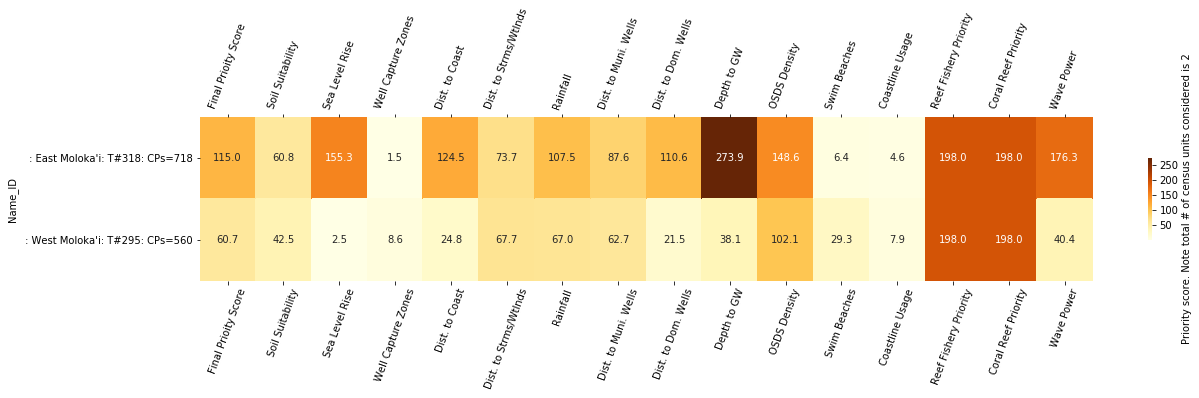

In [104]:
# Plot out comparison heatmap 

Total_census_tracts = 3

fig, ax = plt.subplots(figsize=(20, 3))
total_num = len(compare_priority_score_Track)
#plt.title("Ranks for all {} census Tracks".format(total_num), fontsize=18, y=1.05)
plt.tick_params(axis='x', which='major', labelsize=10, labelbottom = True, bottom=True, top = True, labeltop=True)
plt.xticks(rotation=70)
bar_label = "Priority score. Note total # of census units considered is {}".format(len(Tracks_priority_frame_base['OSDS_count']))
g= sns.heatmap(compare_priority_score_Track, annot=True,  cmap = 'YlOrBr', fmt=".1f", cbar_kws={'label': bar_label, "shrink": 0.5})
plt.savefig(os.path.join(".", "Outputs/Figures", "Tracks_Master_scores_chart.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(".", "Outputs/Figures", "Tracks_Master_scores_chart.png"), bbox_inches='tight')

print_info_for_islands("Molokai", Tracks_priority_frame_base, Total_census_tracts)

#### Quick calculation of how many cesspools are in each catergory 

In [105]:
OSDS_Sum_Piv = pd.pivot_table(Tracks_priority_frame_base, index='Final_Cat_Ranking', aggfunc = 'sum')
OSDS_Sum_Piv['OSDS_pct_in_rank'] = OSDS_Sum_Piv['OSDS_count']/len(OSDS)*100
OSDS_Sum_Piv[['OSDS_count', 'OSDS_pct_in_rank']]
# 62% in Low,  21% in Med, 16% in High

,OSDS_count,OSDS_pct_in_rank
Final_Cat_Ranking,,
High,718,56.09375
Low,560,43.75000


## Save Census Area Shapefiles
!! SUPER LONG RUNTIMES ON CELLS BELOW !!

### Print Shapefile, summarized by census Tracts 


In [107]:
# For tracks 
UnitCol=['Track_ID']
# Cols for all of the below
OutCols = ['Final_Prioity_Score', 'OSDS_count']  #  'PepPerHos', # 'Final_Prioity_Rank', 
all_cols = UnitCol + OutCols + Rank_Cols +['In_2017_CP_zone', 'Final_Cat_Ranking', 'Fin_Rank',]   # 'Final_Cat_Ranking'  comment out rank cols to just print simple shapefile
clean_cols = UnitCol + OutCols +['In_2017_CP_zone','Final_Cat_Ranking', 'Fin_Rank']   #  

# Group up the OSDS units into census areas 
Tracks_priority_frame = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=25)
Tracks_priority_frame =   Tracks_priority_frame.merge(Track_meta, on='Track_ID', how='left')  # Add in the name ID from the Track_meta in above cell
Tracks_priority_frame['Name_ID'] = Tracks_priority_frame['Name_ID']+": CPs="+Tracks_priority_frame['OSDS_count'].astype(str)
Tracks_priority_frame.set_index("Name_ID", drop=True, inplace=True)

# Save Full Shapefile 
Pivot_df = Tracks_priority_frame[all_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_census_tracts_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Tracts_Full.shp')  
make_census_unit_SHP(Pivot_df, all_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Tracts_Full.csv'))

# Save clean Shapefile 
Pivot_df = Tracks_priority_frame[clean_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_census_tracts_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Tracts_Clean.shp')  
make_census_unit_SHP(Pivot_df, clean_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Tracts_Clean.csv'))

### Print Shapefile, summarized by census Block_Groups 

In [109]:
UnitCol=['BlockGp_ID']
# Cols for all of the below
OutCols = ['Final_Prioity_Score', 'OSDS_count']  #  'PepPerHos', # 'Final_Prioity_Rank', 
all_cols = UnitCol + OutCols + Rank_Cols +['In_2017_CP_zone', 'Final_Cat_Ranking', 'Fin_Rank',]   # 'Final_Cat_Ranking'  comment out rank cols to just print simple shapefile
clean_cols = UnitCol + OutCols +['In_2017_CP_zone','Final_Cat_Ranking', 'Fin_Rank']   # 

Block_groups_priority_frame = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=20)
# get the name metadata from other metadata files
Block_groups_meta = get_blkGrp_names(os.path.join("..", "Projected_data/Census/With_2017_priority", '2010_Census_Block_Groups_Meta_w2017.shp'), 'BlockGp_ID')
Block_groups_priority_frame =   Block_groups_priority_frame.merge(Block_groups_meta, on=UnitCol, how='left')  # Add in the name ID from the Track_meta in above cell
Block_groups_priority_frame['Name_ID'] = Block_groups_priority_frame['Name_ID']+": CPs="+Block_groups_priority_frame['OSDS_count'].astype(str)
Block_groups_priority_frame.set_index("Name_ID", drop=True, inplace=True)

# Save Full Shapefile 
Pivot_df = Block_groups_priority_frame[all_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Block_Groups_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_BlockGrps_Full.shp') 
make_census_unit_SHP(Pivot_df, all_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_BlockGrps_Full.csv'))

# Save clean Shapefile 
Pivot_df = Block_groups_priority_frame[clean_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Block_Groups_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_BlockGrps_Clean.shp') 
make_census_unit_SHP(Pivot_df, clean_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_BlockGrps_Clean.csv'))

### Print Shapefile, summarized by census Blocks

In [110]:
UnitCol=['BlockBk_ID']
# Cols for all of the below
OutCols = ['Final_Prioity_Score', 'OSDS_count']  #  'PepPerHos', # 'Final_Prioity_Rank', 
all_cols = UnitCol + OutCols + Rank_Cols +['In_2017_CP_zone', 'Final_Cat_Ranking', 'Fin_Rank',]   # 'Final_Cat_Ranking'  comment out rank cols to just print simple shapefile
clean_cols = UnitCol + OutCols +['In_2017_CP_zone','Final_Cat_Ranking', 'Fin_Rank']   # 

Blocks_priority_frame = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=10)

# Save full shapefile 
Pivot_df = Blocks_priority_frame[all_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Blocks_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Blocks_Full.shp') 
make_census_unit_SHP(Pivot_df, all_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Blocks_Full.csv'))

# Save clean Shapefile 
Pivot_df = Blocks_priority_frame[clean_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Blocks_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Blocks_Clean.shp') 
make_census_unit_SHP(Pivot_df, clean_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Blocks_Clean.csv'))



To DO next - 

Identify where the breakpoint score lines are for Tracks blks and grps in the statewide model, and then rewright the code here to use those same breakpoints 



Tracks 
Break High   97.784082   to 100.050556  =   100.0
Break Medium 81.427021   to 81.861728   =   81.5


Block Groups
Break High   103.867477 to  104.450984  =   104.0
Break Medium 81.554107 to 81.578751     =   81.56

Blocks
Break High   92.884787 to 92.929719     =   92.9
Break Medium 72.967675 to 73.016669     =   73.0 

## DELETE  large files >100mb from offsite repo 
- Some of the files this notebook depends on are too large to be hosted by GitHub
- One solution is to place these files into a cloud-based repositiry, in this case I use Digital Ocean spaces, and then just download them at the beginning of the work session
- Once the analysis is complete USE THIS CELL to remove these files from the Github Repo so any updates dont include the large files 

In [111]:
## Get rid of the Lidar files 
delete_downloaded_files(LIDAR_file_urls, LIDAR_local_folder)

NameError: name 'LIDAR_file_urls' is not defined